# Principal Component Analysis and Agglomerative Hierarchical Clustering

This notebook aims on applying the *Principal Component Analysis* and *Agglomerative Hierarchical Clustering* algorithms in a dataset in order to categorize countries based on some parameters, such as income, life expectation, imports, exports, and interpreting the results gotten.

### Methods Description

- Principal Component Analysis is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.


- Agglomerative Hierarchical Clustering is a clustering method used to group objects in clusters based on their similarity.

In [1]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from numpy.linalg import eig
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

warnings.filterwarnings("ignore")
sns.set()

## First look at the dataset

In [2]:
# Getting Data
df_countries = pd.read_csv(r'Data/countries.csv')
df_countries.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Reindexing 
df_countries = df_countries.set_index('country')

In [4]:
# Descriptive Statistics
df_countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


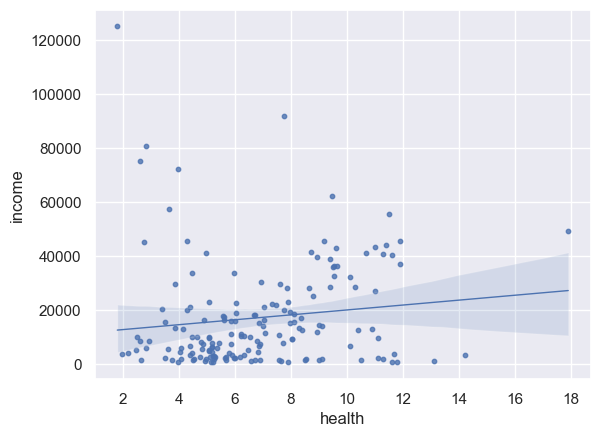

In [5]:
# Plotting 'health', 'income' values and a linear regression model fit
sns.regplot(df_countries['health'], df_countries['income'], line_kws={"lw":1}, scatter_kws={"s": 10})
plt.show()

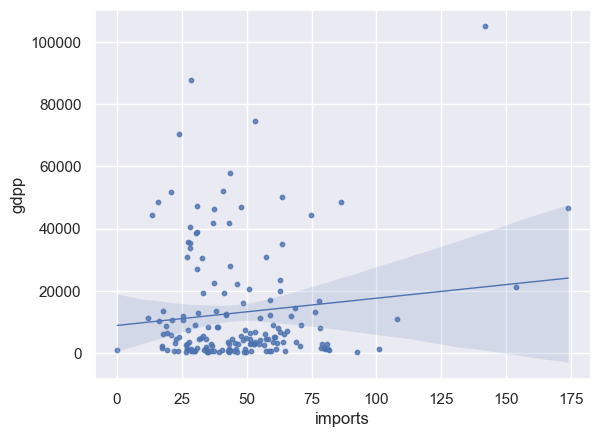

In [6]:
# Plotting 'imports', 'gdpp' values and a linear regression model fit
sns.regplot(df_countries['imports'], df_countries['gdpp'], line_kws={"lw":1}, scatter_kws={"s": 10})
plt.show()

## Principal component analysis

The PCA methods is based on the correlation between the parameters.

The Bartlett's Test of Sphericity compares an observed correlation matrix to the identity matrix, if the p-value < 0.05, the parameters are not correlated, so there's no point on applying the PCA.

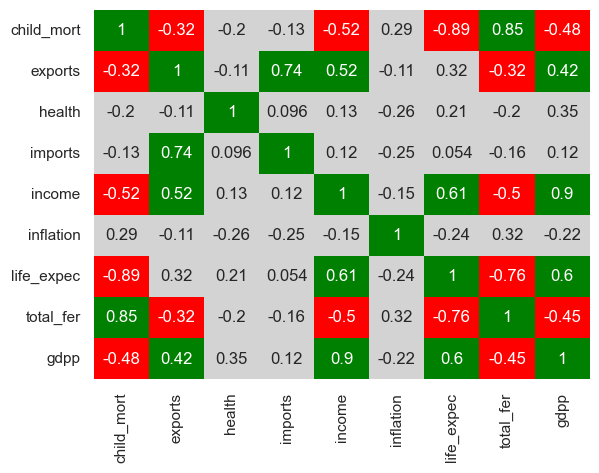

In [7]:
# Correlation matrix with colors
df_corr = df_countries.corr()
sns.heatmap(df_corr, annot=True, cmap = ["red", "lightgrey", "green"], cbar=False)
plt.show()

In [8]:
# Bartlett's Test of Sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_countries)
if p_value < 0.05:
    print('PCA can be applied.')
else:
    print('PCA cannot be applied.')

PCA can be applied.


Once it's noticed that the PCA can be applied, the number of factors used will be defined by the Kaiser Rule (eigenvalues > 1)

In [9]:
# Defining number of values
v, w = np.linalg.eig(df_corr.values.astype(float))
n_comp = (v>1).sum()
print(f'Applying the Kaiser Rule, {n_comp} factors will be used.')

Applying the Kaiser Rule, 3 factors will be used.


In [10]:
# Normalizing Data
scaler = StandardScaler()
df_countries_normalized = scaler.fit_transform(df_countries)

In [11]:
# PCA
pca = PCA(n_components = n_comp, whiten=True)
df_countries_pca = pca.fit_transform(df_countries_normalized)

In [12]:
# Total percentage of variance explained
print(f'The {n_comp} components will keep {round((pca.explained_variance_ratio_.sum()*100),2)}% of the original Dataset variance.')

The 3 components will keep 76.14% of the original Dataset variance.


In [13]:
# Total percentage of variance explained for n_comp + 1
print(f'For {n_comp+1} components {round((PCA(n_components = n_comp+1, whiten=True).fit(df_countries_normalized).explained_variance_ratio_.sum()*100),2)}% of would be maintained.')

For 4 components 87.19% of would be maintained.


As the PCA aims on reducing the number of parameters, some of the original dataset variance will be lost.

In this case, 76% of the variance is maintained considering the 3 components.

In [14]:
# Factors components
pd.DataFrame(index = ['F1', 'F2', 'F3'], columns = df_countries.columns, data = pca.components_).T

,F1,F2,F3
child_mort,-0.419519,0.192884,-0.029544
exports,0.283897,0.613163,0.144761
health,0.150838,-0.243087,-0.596632
imports,0.161482,0.671821,-0.299927
income,0.398441,0.022536,0.301548
inflation,-0.193173,-0.008404,0.642520
life_expec,0.425839,-0.222707,0.113919
total_fer,-0.403729,0.155233,0.019549
gdpp,0.392645,-0.046022,0.122977


Description of wich parameters weight on the different factors.

For example, the second factor is highly correlated to 'imports' and 'exports' 

In [15]:
# Factors added to dataframe
df_countries = pd.merge(df_countries, pd.DataFrame(df_countries_pca, index = df_countries.index, columns=['F1', 'F2', 'F3']), how='inner', left_index=True, right_index=True)
df_countries.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,F1,F2,F3
country,,,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,-1.428130,0.076664,-0.661802
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0.210767,-0.471558,-0.307333
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,-0.139834,-0.364939,1.125711
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,-1.437640,1.359422,1.405446
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0.506718,0.109567,-0.208019


## Agglomerative Hierarchical Clustering

The countries will be grouped using the Agglomerative Hierarchical Clustering method considering the gotten factors. The method's main challenge is defining the ideal number of clusters and, in order to find it a dendrogram will be plotted.

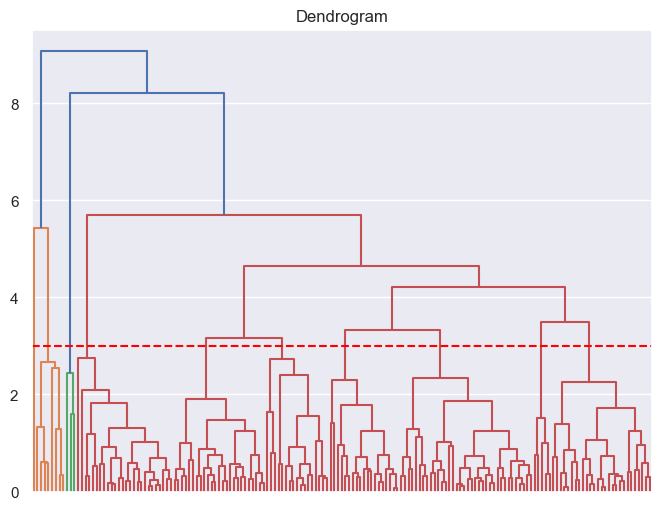

In [16]:
# Plotting dendrogram
clusters = hierarchy.linkage(df_countries_pca, method="complete")
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)
plt.axhline(3, color='red', linestyle='--')
plt.xticks([])
plt.title('Dendrogram')
plt.show()

Analyzing the Dendrogram (considering the grouping distances), 10 clusters seems to be a good choice.

In [17]:
# Applying the Agglomerative Hierarchical Clustering considering the factors
clustering_model = AgglomerativeClustering(n_clusters=10, linkage="complete")
clustering_model.fit(df_countries_pca)
labels = clustering_model.labels_

In [18]:
# Adding the cluster labels to the DataFrame
df_countries['cluster'] = labels
df_countries.head(15)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,F1,F2,F3,cluster
country,,,,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,-1.428130,0.076664,-0.661802,4
Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0.210767,-0.471558,-0.307333,5
Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,-0.139834,-0.364939,1.125711,6
Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,-1.437640,1.359422,1.405446,7
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0.506718,0.109567,-0.208019,5
Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0.010985,-1.426474,0.801770,6
Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,-0.049802,-0.455599,0.223106,5
Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1.148262,-1.594260,0.175417,0
Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1.457908,-0.589041,-0.479005,0


## Statistical Descriptions of the Clusters

In [19]:
# Creating a Dataframe with the parameters means grouped by clusters
df_clusters = pd.DataFrame(index = df_countries['cluster'].value_counts().index, columns = df_countries.columns[0:9])
for column in df_clusters.columns:
    df_clusters[column] = df_countries.groupby('cluster')[column].agg('mean')
df_clusters['count'] = df_countries['cluster'].value_counts()
df_clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,count
5,14.311111,42.277778,7.488333,52.558333,16968.055556,3.569056,75.425000,1.907222,13079.444444,36
6,39.425926,26.632556,4.892593,26.028367,9317.037037,14.837778,69.937037,3.015926,4025.555556,27
0,6.603846,30.942308,9.847692,30.903846,32276.923077,2.315615,79.542308,1.797692,34201.923077,26
4,90.560000,31.576000,5.948800,43.984000,2600.760000,7.641800,58.200000,5.079600,1254.760000,25
8,16.273684,68.368421,6.145263,72.505263,16812.631579,4.551842,73.573684,2.181053,10049.473684,19
1,80.635294,19.660000,8.592941,54.458824,2740.823529,5.401765,60.111765,4.365294,1562.647059,17
3,12.500000,60.437500,3.348750,34.962500,59400.000000,17.535000,76.750000,2.341250,30412.500000,8
7,90.660000,72.040000,3.340000,52.440000,11610.000000,17.842000,63.500000,4.826000,5802.000000,5
2,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,3
9,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000,1


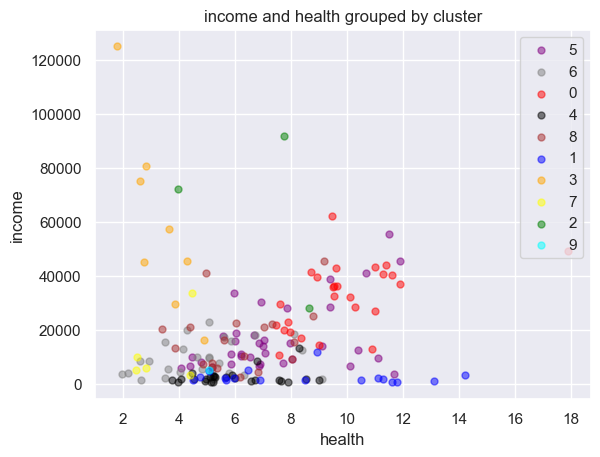

In [20]:
# Plotting 'health', 'income' divided by clusters
labels = ['red', 'blue', 'green', 'orange', 'black', 'purple', 'grey', 'yellow', 'brown', 'aqua']
for cluster in df_clusters.index:
    plt.scatter(df_countries['health'].loc[df_countries['cluster'] == cluster], df_countries['income'].loc[df_countries['cluster'] == cluster], color = labels[cluster], s=25, alpha=.5 )
plt.legend(df_clusters.index)
plt.title('income and health grouped by cluster')
plt.xlabel('health')
plt.ylabel('income')
plt.show()

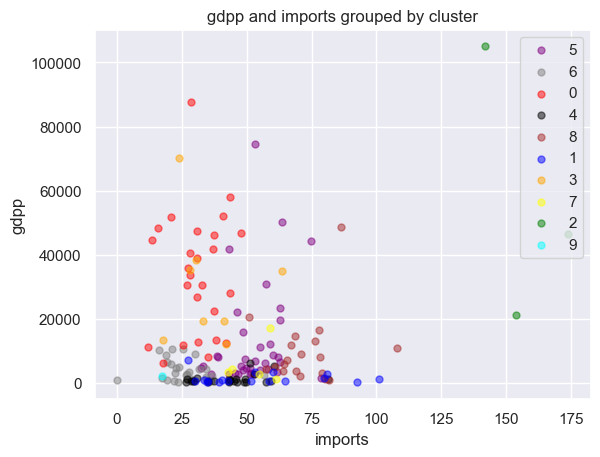

In [21]:
# Plotting 'imports', 'gdpp' divided by clusters
labels = ['red', 'blue', 'green', 'orange', 'black', 'purple', 'grey', 'yellow', 'brown', 'aqua']
for cluster in df_clusters.index:
    plt.scatter(df_countries['imports'].loc[df_countries['cluster'] == cluster], df_countries['gdpp'].loc[df_countries['cluster'] == cluster], color = labels[cluster], s=25, alpha=.5 )
plt.legend(df_clusters.index)
plt.title('gdpp and imports grouped by cluster')
plt.xlabel('imports')
plt.ylabel('gdpp')
plt.show()